In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, gc, os, glob
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
sys.path.append('/Volumes/GoogleDrive/My Drive/ASU/Codes/PythonCode/modules')

import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter
import numpy as np
from IPython import display

from scipy.interpolate import spline
from scipy.optimize import curve_fit

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

import loadSP as lsp

import pandas as pd
import seaborn as sns
# sns.set(color_codes=True)
sns.set(style="whitegrid", font_scale=2, color_codes=True)
sns.set_style({'axes.edgecolor': '0.0','axes.linewidth': 2.0})

plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams.update({'font.size': 28, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
#plt.rcParams['font.size'] = 28

pd.set_option('precision', 5)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
np.set_printoptions(linewidth=170)

In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)


nullfmt = NullFormatter()
labelsize = 24

In [3]:
halos_z9_pos, halos_z9_masses, halos_z9_rad = lsp.loadHMHalos(prefix='fid/',num=35)

In [4]:
num_to_z = {56:7,44:8,35:9,30:10,25:11,21:12,18:13,15:14,13:15}
sorted(num_to_z.keys())

[13, 15, 18, 21, 25, 30, 35, 44, 56]

In [5]:
# Load the DM halo data into a dict

halos = {}
halos = {num_to_z[i]: (lsp.loadHMHalos(prefix='fid/',num=i)) for i in sorted(num_to_z.keys())}

In [6]:
[print("z= {}, mean halo mass={:.3e}".format(i, halos[i][1].mean())) for i in sorted(num_to_z.values())] 

z= 7, mean halo mass=8.200e+07
z= 8, mean halo mass=7.088e+07
z= 9, mean halo mass=6.288e+07
z= 10, mean halo mass=5.742e+07
z= 11, mean halo mass=5.331e+07
z= 12, mean halo mass=4.965e+07
z= 13, mean halo mass=4.717e+07
z= 14, mean halo mass=4.487e+07
z= 15, mean halo mass=4.226e+07


[None, None, None, None, None, None, None, None, None]

In [7]:
sorted(num_to_z.values())

[7, 8, 9, 10, 11, 12, 13, 14, 15]

In [8]:
mbins = np.logspace(7,11,31)
n, bins = np.histogram(halos[7][1],bins=mbins,density=False)
(n/n.sum()).sum()

1.0

In [9]:
mbins

array([1.00000000e+07, 1.35935639e+07, 1.84784980e+07, 2.51188643e+07, 3.41454887e+07, 4.64158883e+07, 6.30957344e+07, 8.57695899e+07, 1.16591440e+08, 1.58489319e+08,
       2.15443469e+08, 2.92864456e+08, 3.98107171e+08, 5.41169527e+08, 7.35642254e+08, 1.00000000e+09, 1.35935639e+09, 1.84784980e+09, 2.51188643e+09, 3.41454887e+09,
       4.64158883e+09, 6.30957344e+09, 8.57695899e+09, 1.16591440e+10, 1.58489319e+10, 2.15443469e+10, 2.92864456e+10, 3.98107171e+10, 5.41169527e+10, 7.35642254e+10,
       1.00000000e+11])

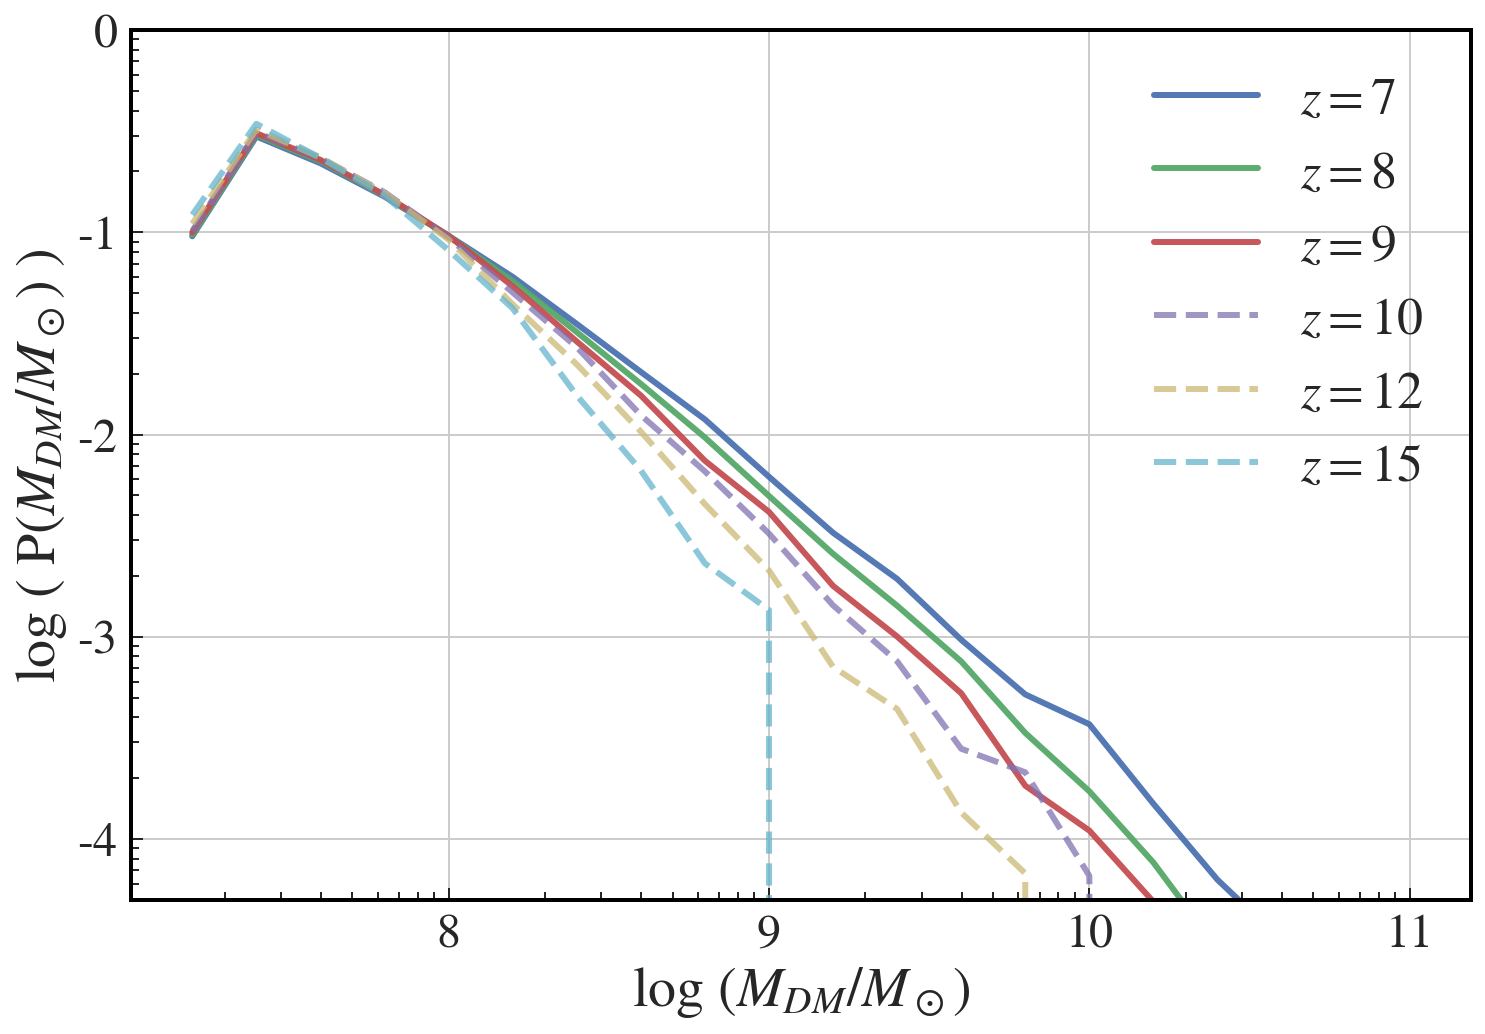

In [10]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

mbins = np.logspace(7,11,21)

colors = ['C0','C1','C2','C3','C4','C4','C5','C5','C5']
for i,c in zip(sorted(num_to_z.values()),colors):
    if i in [11,13,14]:
        continue
    n, bins = np.histogram(halos[i][1],bins=mbins,density=False)
    # Normalize to 1 over entire range... Make PDF
    n = n/n.sum()
    if i >= 10:
        al = 0.75
        ls = '--'
    else:
        al = 0.95
        ls = '-'
    ax.plot(mbins[1:], n, '-', lw=3.0, ls=ls, color=c, alpha=al, label="$z=${}".format(i) )

#     plt.plot([halos[i][1].mean(),halos[i][1].mean()],[1e0,4e4])
ax.set_yscale('log')
ax.set_xscale('log')
ax.yaxis.set_tick_params(which='major',width=1,length=6)
ax.yaxis.set_tick_params(which='minor',width=1,length=4)
ax.yaxis.set_tick_params(which='both', direction='in',labelsize=24)
ax.xaxis.set_tick_params(which='major',width=1,length=6)
ax.xaxis.set_tick_params(which='minor',width=1,length=4)
ax.xaxis.set_tick_params(which='both', direction='in',labelsize=24)

ax.set_xlabel('log $(M_{DM}/M_\odot)$', fontsize=28)
ax.set_ylabel('log ( P$(M_{DM}/M_\odot)$ )', fontsize=28)
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_ylim([5e-5,1])
ax.legend(fontsize=26)
plt.savefig("HMF.pdf",dpi=fig.dpi,bbox_inches='tight')

In [11]:
# Return estimated grav binding energy per halo
# based on DM mass and z

# Returns value in units of ***** E_51 *****
def bindingE(m,z):
    return (2.9e53 * (m/1e8)**(5./3.)*(1+z)/10)/1e51

In [12]:
# Define a function that fits a simple 2d poly to the
# mean of the 

the_nums = sorted(num_to_z.keys())
the_zs   = sorted(num_to_z.values())
def redshift_vs_mean(the_zs,a,b,c):
    return (a*(the_zs**2) + b*the_zs + c)

In [13]:
sn_energy = 8e53/1e51 # Based on the SP mass, fraction of SP mass that goes SN and SN energy per 10 M_sun (10^51 erg/10 M_sun)
sn_energy/4.75, 1/4.75

(168.42105263157896, 0.21052631578947367)

In [14]:
[bindingE(halos[i][1].mean(),i) for i in the_zs]

[166.66974215061117,
 147.05077696763212,
 133.84848241500478,
 126.55533132093824,
 121.95893257738643,
 117.3545896239936,
 116.05666767654158,
 114.39252694567864,
 110.434697159908]

In [15]:
np.array([bindingE(np.median(halos[i][1]),i) for i in the_zs]).min(),np.array([bindingE(np.median(halos[i][1]),i) for i in the_zs]).max()

(32.80100323050375, 50.85724670530477)

In [16]:
np.array([bindingE(np.median(halos[i][1]),i) for i in the_zs])

array([32.80100323, 35.49972996, 38.23306901, 41.3730402 , 43.70858263, 45.42144177, 48.1054574 , 49.82340846, 50.85724671])

[834.58105327 503.04281575 726.45434595 ...  18.82655735  13.22681058  12.53345635]
[  80.98040393 1277.68271106   17.7184587  ...   11.00338976   28.10595696   12.98147114]
[1124.20928795  332.54293255  288.40675514 ...   79.14746569   11.47278402   15.24793769]
[ 336.95464304  334.67528787 1736.7599172  ...   17.95080503   15.86624251   13.44858748]
[ 353.91705071 1734.71118609  183.59541197 ...   16.66245732   19.82231899   45.04476967]
[ 18.35645444  79.6206929  334.41470403 ...  32.61471679  61.65507342  58.27811017]


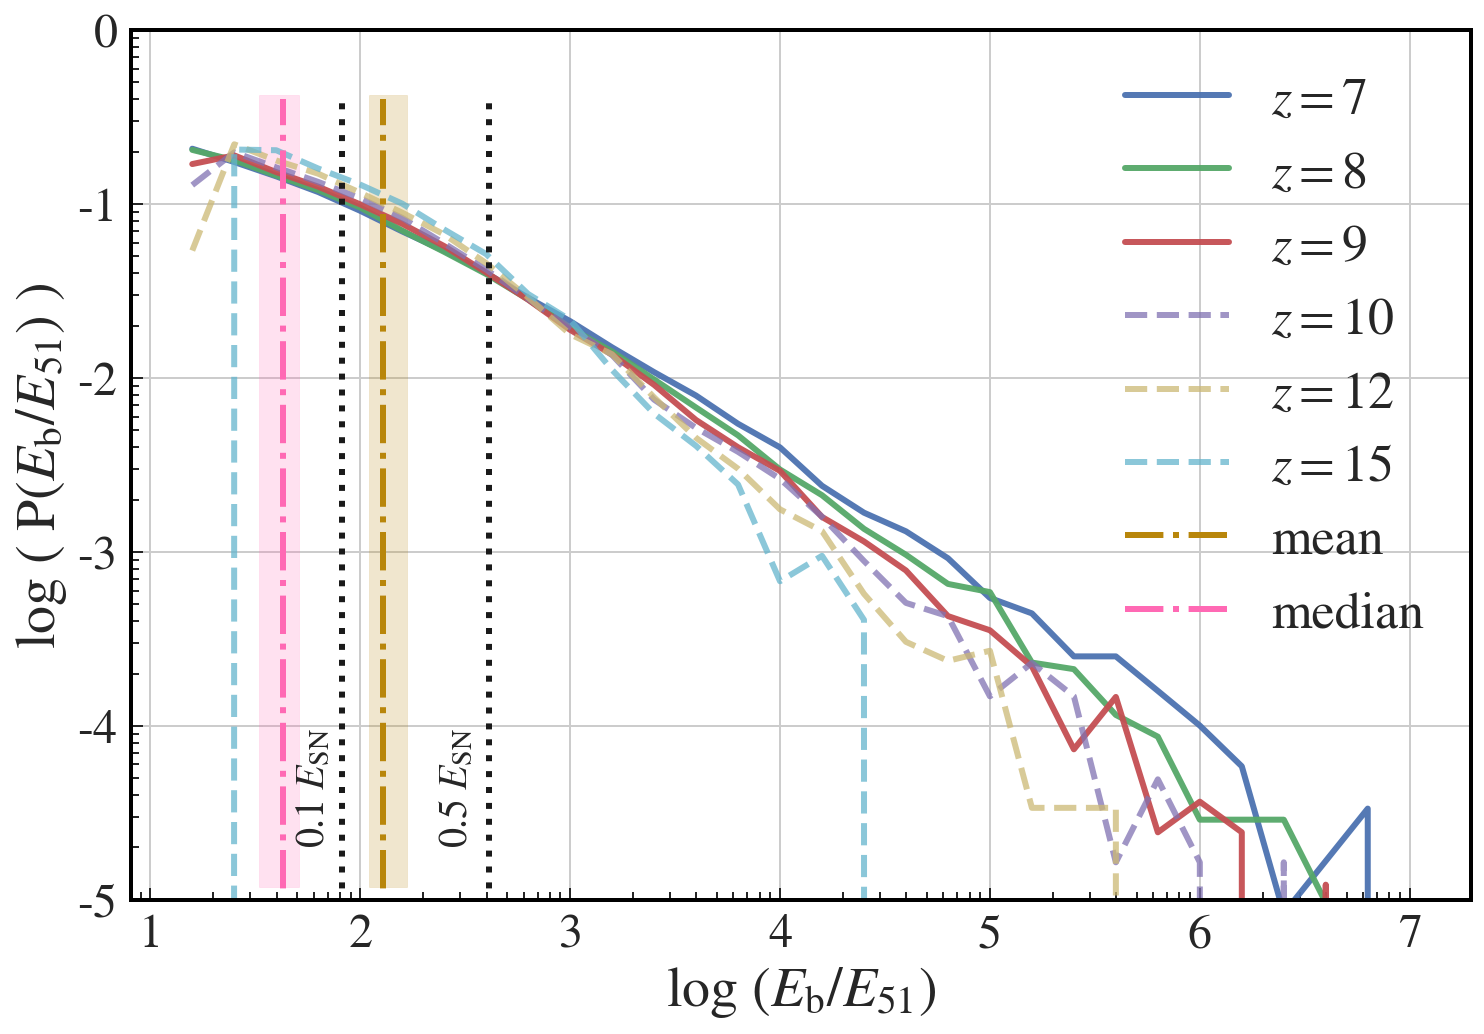

In [17]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

sn_energy = 8.2e53/1e51 # Based on the SP mass, fraction of SP mass that goes SN and SN energy per 10 M_sun (10^51 erg/10 M_sun)

bbins = np.logspace(1,7,31)

colors = ['C0','C1','C2','C3','C4','C4','C5','C5','C5']
for i,c in zip(sorted(num_to_z.values()),colors):
    if i in [11,13,14]:
        continue
    n, bins = np.histogram(bindingE(halos[i][1],i),bins=bbins,density=False)
    # Normalize to 1 over entire range... Make PDF
    n = n/n.sum()
    if i >= 10:
        al = 0.75
        ls = '--'
    else:
        al = 0.95
        ls = '-'
#     ax.plot(bbins[1:], n, '-', drawstyle='steps', lw=3.0, ls=ls, color=c, alpha=al, label="$z=${}".format(i))
    ax.plot(bbins[1:], n, '-', lw=3.0, ls=ls, color=c, alpha=al, label="$z=${}".format(i))

    print(bindingE(halos[i][1],i))
ax.plot([sn_energy/10.0,sn_energy/10.0],[5e-6,.4],lw = 3, ls=":", c='k')
ax.annotate(r'$0.1\; {E_{\mathrm{SN}}}$', xy = (0.5, 0.5), xytext = (sn_energy/10.0 - sn_energy/25,2e-5), xycoords='figure fraction',
            textcoords = 'data', ha = 'left', va = 'bottom', rotation=90, fontsize=20)
    
ax.plot([sn_energy/2.0,sn_energy/2.0],[5e-6,.4],lw = 3, ls=":", c='k')
ax.annotate(r'$0.5\; {E_{\mathrm{SN}}}$', xy = (0.5, 0.5), xytext = (sn_energy/2.0 - sn_energy/4.7,2e-5), xycoords='figure fraction',
            textcoords = 'data', ha = 'left', va = 'bottom', rotation=90, fontsize=20)

# ax.plot([sn_energy,sn_energy],[5e-6,.4],lw = 3, ls=":", c='k')
# ax.annotate(r'     ${E_{\mathrm{SN}}}$', xy = (0.5, 0.5), xytext = (sn_energy - sn_energy/2.5,2e-5), xycoords='figure fraction',
#             textcoords = 'data', ha = 'left', va = 'bottom', rotation=90, fontsize=20)

# Mean mean and median binding energies (across all zs)
mean_Eb = np.array([bindingE(halos[i][1].mean(),i) for i in the_zs]).mean()
median_Eb = np.array([bindingE(np.median(halos[i][1]),i) for i in the_zs]).mean()

low_Mean_Eb = np.array([bindingE(halos[i][1].mean(),i) for i in the_zs]).min()
hi_Mean_Eb  = np.array([bindingE(halos[i][1].mean(),i) for i in the_zs]).max()

low_Med_Eb = np.array([bindingE(np.median(halos[i][1]),i) for i in the_zs]).min()
hi_Med_Eb  = np.array([bindingE(np.median(halos[i][1]),i) for i in the_zs]).max()


ax.plot([mean_Eb,mean_Eb],[5e-6,.4], ls='-.', lw=3, c='darkgoldenrod',
         label=r'mean')
ax.axvspan(low_Mean_Eb,hi_Mean_Eb, ymin=0.015, ymax=0.925, alpha=0.20, color='darkgoldenrod')
ax.plot([median_Eb, median_Eb], [5e-6,.4], lw=3, ls='-.', c='hotpink',
         label=r'median')
ax.axvspan(low_Med_Eb,hi_Med_Eb, ymin=0.015, ymax=0.925, alpha=0.20, color='hotpink')

#     plt.plot([halos[i][1].mean(),halos[i][1].mean()],[1e0,4e4])
ax.set_yscale('log')
ax.set_xscale('log')
ax.yaxis.set_tick_params(which='major',width=1,length=6)
ax.yaxis.set_tick_params(which='minor',width=1,length=4)
ax.yaxis.set_tick_params(which='both', direction='in',labelsize=24)
ax.xaxis.set_tick_params(which='major',width=1,length=6)
ax.xaxis.set_tick_params(which='minor',width=1,length=4)
ax.xaxis.set_tick_params(which='both', direction='in',labelsize=24)

ax.set_xlabel('log $(E_{\mathrm {b}}/E_{\mathrm{51}})$', fontsize=28)
ax.set_ylabel('log ( P$(E_{\mathrm {b}}/E_{\mathrm{51}})$ )', fontsize=28)
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_ylim([1e-5,1])
ax.legend(fontsize=26)
plt.savefig("Ebinding2.pdf",dpi=fig.dpi,bbox_inches='tight')

In [42]:
mean_Eb/ (sn_energy/10.0), sn_energy

(1.5641216081811578, 820.0)

In [51]:
median_Eb,mean_Eb, 0.16 * sn_energy, .21*800

(42.869219929109676, 128.25797187085493, 123.0, 168.0)

In [25]:
# Find fits to the data for the mean mass and the median mass as a function of z
# Need to reverse the numerical indicates when accessing halos since high nums matchup with low redshift
coef_mean, pcov = curve_fit(redshift_vs_mean, sorted(num_to_z.values()), [halos[i][1].mean() for i in sorted(num_to_z.values())])
coef_median, pcov = curve_fit(redshift_vs_mean, sorted(num_to_z.values()), [np.median(halos[i][1]) for i in sorted(num_to_z.values())])

In [26]:
sn_energy/10.

80.0

In [27]:
bindingE(5.3e7,7),bindingE(3.5e7,15),

(80.52815844482261, 80.65501713639661)

In [14]:
the_zs,[bindingE(np.median(halos[i][1]),i) for i in the_zs]

([7, 8, 9, 10, 11, 12, 13, 14, 15],
 [32.801003230503753,
  35.499729959348002,
  38.233069012151383,
  41.373040196160673,
  43.708582631042006,
  45.421441774077522,
  48.105457395008202,
  49.823408458390759,
  50.857246705304767])

mean halo mass z=7 is 8.20e+07
median halo mass z=7 is 3.09e+07
mean halo mass z=8 is 7.09e+07
median halo mass z=8 is 3.02e+07
mean halo mass z=9 is 6.29e+07
median halo mass z=9 is 2.96e+07
mean halo mass z=10 is 5.74e+07
median halo mass z=10 is 2.94e+07
mean halo mass z=11 is 5.33e+07
median halo mass z=11 is 2.88e+07
mean halo mass z=12 is 4.96e+07
median halo mass z=12 is 2.81e+07
mean halo mass z=13 is 4.72e+07
median halo mass z=13 is 2.78e+07
mean halo mass z=14 is 4.49e+07
median halo mass z=14 is 2.72e+07
mean halo mass z=15 is 4.23e+07
median halo mass z=15 is 2.65e+07


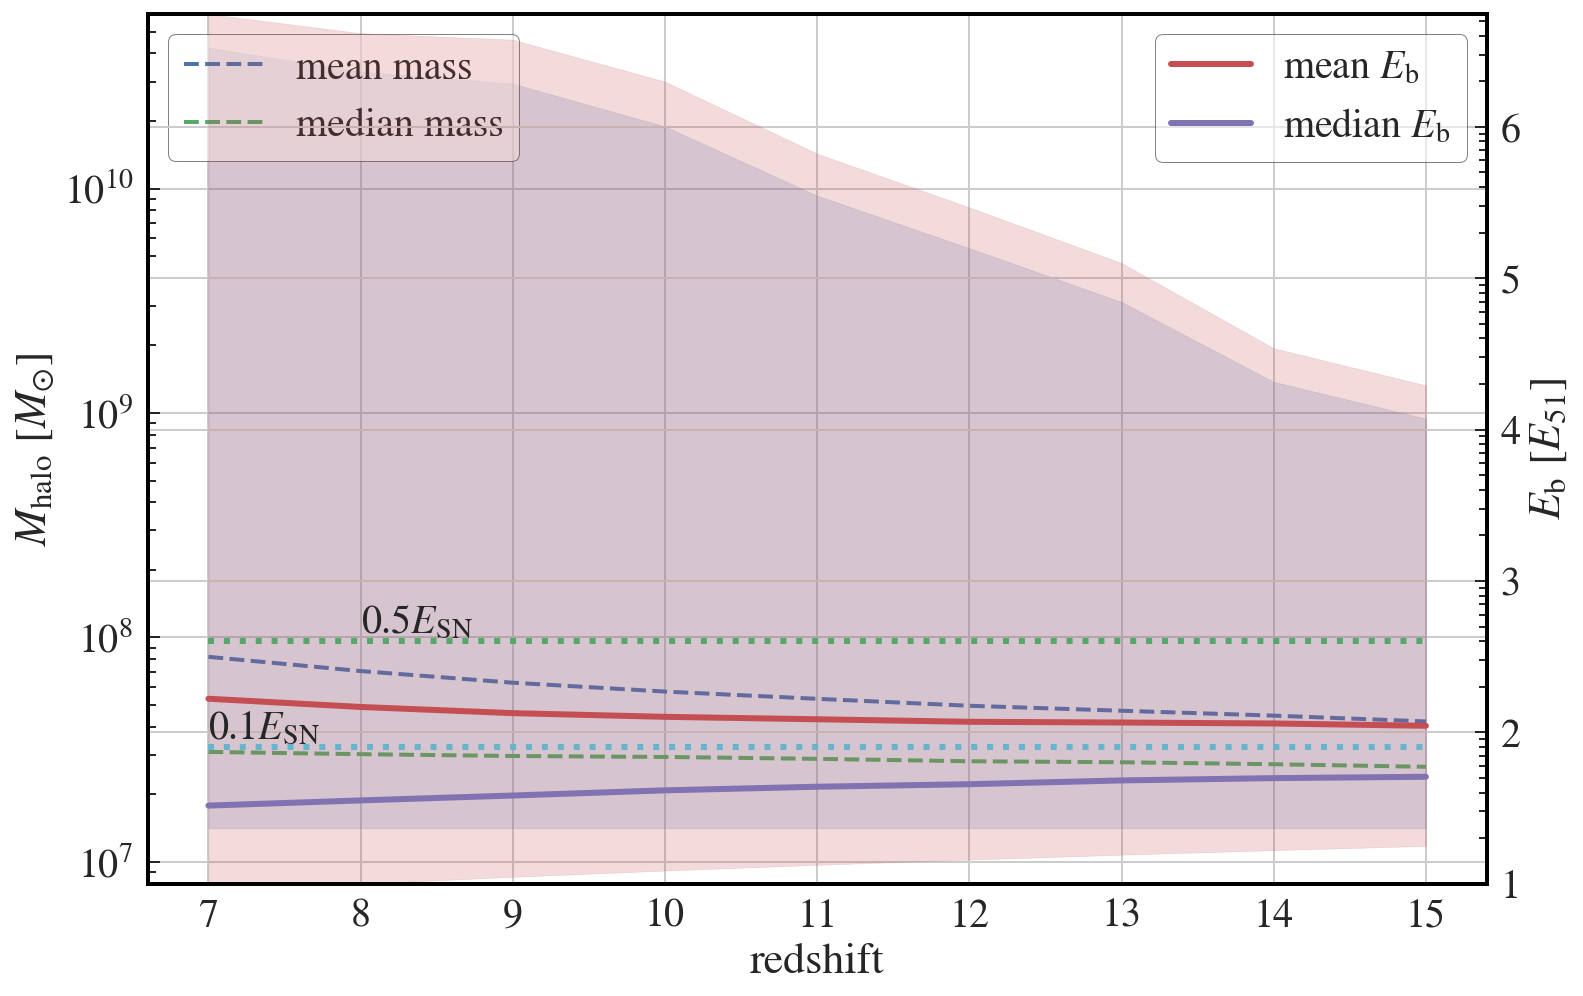

In [15]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

sn_energy = 8e53/1e51

the_zs   = sorted(num_to_z.values())
for i in the_zs:
    print("mean halo mass z={} is {:.2e}".format(i,halos[i][1].mean()))
    print("median halo mass z={} is {:.2e}".format(i,np.median(halos[i][1])))
ax.plot(the_zs,[halos[i][1].mean() for i in the_zs], lw=2, ls='--', c='C0',
        label='mean mass')
ax.fill_between(the_zs,[halos[i][1].min() for i in the_zs],[halos[i][1].max() for i in the_zs],  color='C0', alpha = 0.2)
ax.plot(the_zs,[np.median(halos[i][1]) for i in the_zs], lw=2, ls='--', c='C1',
        label='median mass')

ax.set_yscale('log')
ax.set_ylim([8e6,6e10])
# ax.yaxis.set_major_formatter(logfmt)
ax.yaxis.set_tick_params(which='major',width=1,length=6)
ax.yaxis.set_tick_params(which='minor',width=1,length=4)
ax.get_yaxis().set_tick_params(which='both', direction='in')
# ax.set_yticks([1e7,1e8])
# ax.set_yticklabels([7,7.3,8])

ax.set_xlabel('redshift')
ax.set_ylabel('$M_{\mathrm{halo}}$ [$M_{\odot}$]')

# Top x-axis labels ... m_ab
ax2 = ax.twinx() # Use the same x axis
ax2.set_yscale('log')
ax2.yaxis.set_tick_params(which='major',width=1,length=6)
ax2.yaxis.set_tick_params(which='minor',width=1,length=4)
ax2.get_yaxis().set_tick_params(which='both', direction='in')
ax2.get_xaxis().set_tick_params(labelsize=24)
ax2.plot(the_zs,[bindingE(halos[i][1].mean(),i) for i in the_zs], lw=3, c='C2',
         label=r'mean $E_{\mathrm {b}}$')
ax2.plot(the_zs,[bindingE(np.median(halos[i][1]),i) for i in the_zs], lw=3, c='C3',
         label=r'median $E_{\mathrm {b}}$')
ax2.fill_between(the_zs,
                 [bindingE(halos[i][1].min(),i) for i in the_zs],
                 [bindingE(halos[i][1].max(),i) for i in the_zs],  color='C2', alpha = 0.2)
# Add lines for typical SN energy
ax2.plot(the_zs,np.full(len(num_to_z.keys()),sn_energy/10.0),lw = 3, ls=":", c='C5')
ax2.annotate(r'$0.1 {E_{\mathrm{SN}}}$', xy = (0.5, 0.5), xytext = (7, sn_energy/10.0), xycoords='figure fraction',
            textcoords = 'data', ha = 'left', va = 'bottom',fontsize=20)
ax2.plot(the_zs,np.full(len(num_to_z.keys()),sn_energy/2.0),lw = 3, ls=":", c='C7')
ax2.annotate(r'$0.5 {E_{\mathrm{SN}}}$', xy = (0.5, 0.5), xytext = (8, sn_energy/2.0), xycoords='figure fraction',
            textcoords = 'data', ha = 'left', va = 'bottom',fontsize=20)
# ax2.set_ylim([30,200])
ax2.set_ylim([10,5567049])
# ax2.set_yticklabels([40,60,80,100])
# ax2.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
# ax2.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
ax2.yaxis.set_major_formatter(logfmt)
# ax2.yaxis.set_minor_formatter(logfmt)
ax2.set_ylabel('$E_{\mathrm {b}}$ [$E_{\mathrm{51}}$]')
# ax.plot(the_zs,redshift_vs_mean(np.array(the_zs),coef_mean[0],coef_mean[1],coef_mean[2]), label='fit mean')
# ax.plot(the_zs,redshift_vs_mean(np.array(the_zs),coef_median[0],coef_median[1],coef_median[2]), label='fit median')

lk = ax.legend(loc=2,framealpha=0.55, fancybox=True, edgecolor='k')
# lk = ax.legend(loc=1,framealpha=0.55, fancybox=True, edgecolor='k')
lk.get_frame().set_linewidth(0.5)
lk.set_frame_on(True)

lk2= ax2.legend(loc=1,framealpha=0.55, fancybox=True, edgecolor='k')
lk2.get_frame().set_linewidth(0.5)
lk2.set_frame_on(True)


In [168]:
bindingE(8.20e+07,7),bindingE(3.09e+07,7)

(166.66499957042058, 32.765649704746956)

In [214]:
[bindingE(halos[i][1].min(),i) for i in the_zs], np.log10([bindingE(halos[i][1].max(),i) for i in the_zs])

([8.8827167316315965,
  9.9930563230855469,
  11.103395914539497,
  12.213735505993444,
  13.324075097447393,
  14.434414688901345,
  15.544754280355292,
  16.655093871809243,
  17.765433463263193],
 array([ 6.74562509,  6.61839559,  6.57535433,  6.29856359,  5.82240595,  5.46752242,  5.10004928,  4.53694374,  4.29182393]))

In [215]:
the_nums, the_zs

([13, 15, 18, 21, 25, 30, 35, 44, 56], [7, 8, 9, 10, 11, 12, 13, 14, 15])

mean halo mass z=7 is 8.20e+07
median halo mass z=7 is 3.09e+07
mean halo mass z=8 is 7.09e+07
median halo mass z=8 is 3.02e+07
mean halo mass z=9 is 6.29e+07
median halo mass z=9 is 2.96e+07
mean halo mass z=10 is 5.74e+07
median halo mass z=10 is 2.94e+07
mean halo mass z=11 is 5.33e+07
median halo mass z=11 is 2.88e+07
mean halo mass z=12 is 4.96e+07
median halo mass z=12 is 2.81e+07
mean halo mass z=13 is 4.72e+07
median halo mass z=13 is 2.78e+07
mean halo mass z=14 is 4.49e+07
median halo mass z=14 is 2.72e+07
mean halo mass z=15 is 4.23e+07
median halo mass z=15 is 2.65e+07


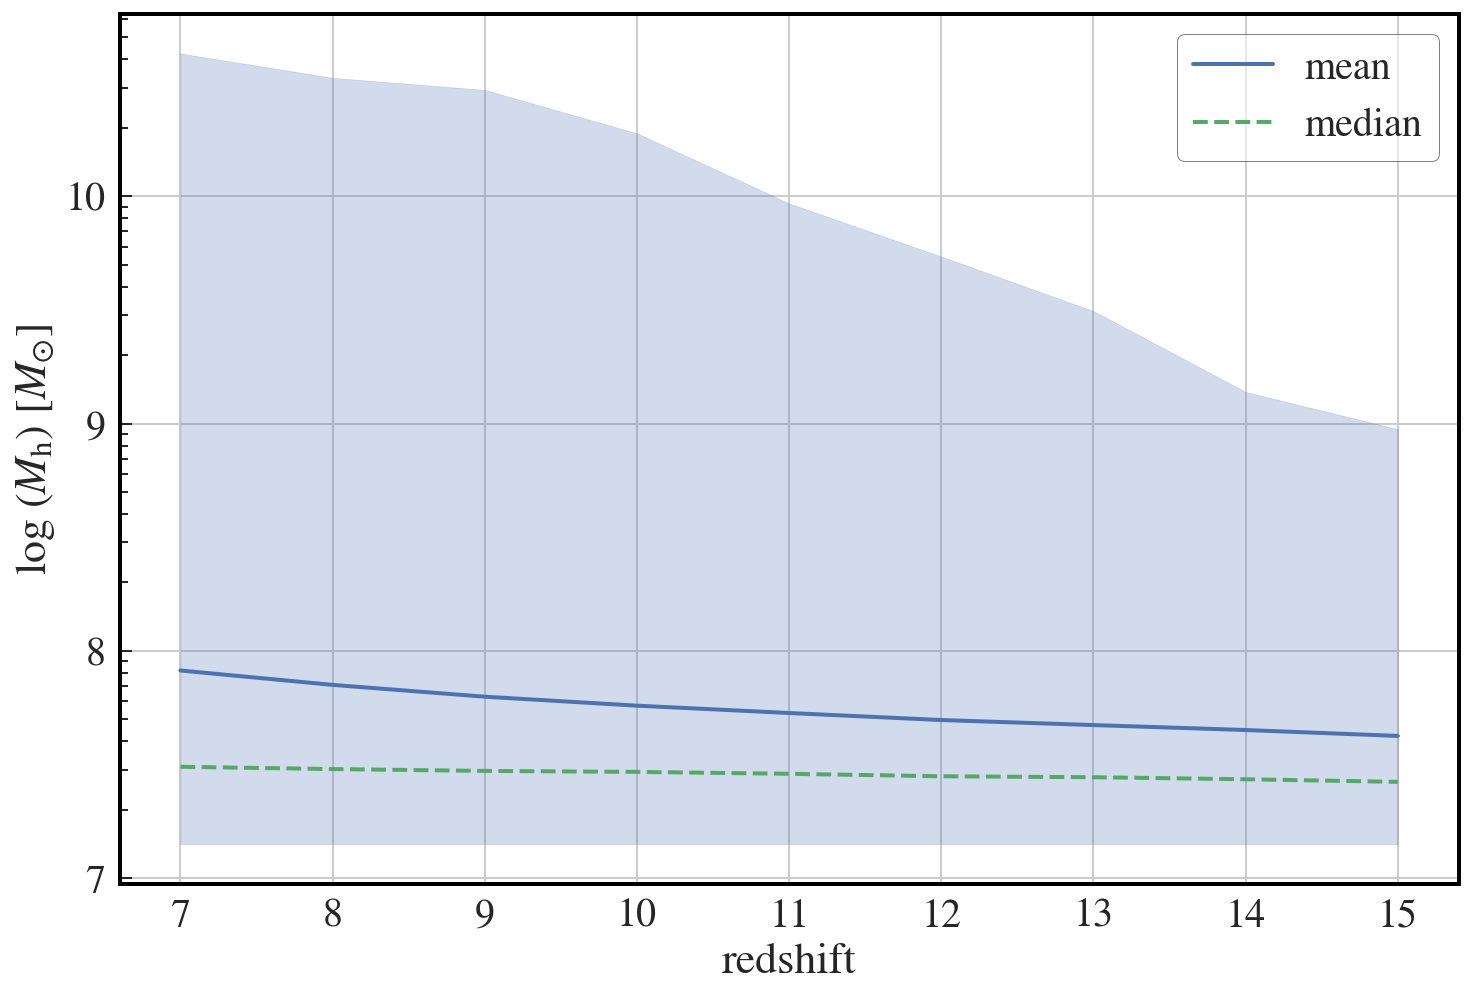

In [217]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

sn_energy = 8e53/1e51

the_zs   = sorted(num_to_z.values())
for i in the_zs:
    print("mean halo mass z={} is {:.2e}".format(i,halos[i][1].mean()))
    print("median halo mass z={} is {:.2e}".format(i,np.median(halos[i][1])))
ax.plot(the_zs,[halos[i][1].mean() for i in the_zs], lw=2, ls='-', c='C0',
        label='mean')
ax.fill_between(the_zs,[halos[i][1].min() for i in the_zs],[halos[i][1].max() for i in the_zs], 
                color='C0', alpha = 0.25)
ax.plot(the_zs,[np.median(halos[i][1]) for i in the_zs], lw=2, ls='--', c='C1',
        label='median')

ax.set_yscale('log')
ax.yaxis.set_major_formatter(logfmt)
ax.yaxis.set_tick_params(which='major',width=1,length=6)
ax.yaxis.set_tick_params(which='minor',width=1,length=4)
ax.get_yaxis().set_tick_params(which='both', direction='in')
# ax.set_yticks([1e7,1e8])
# ax.set_yticklabels([7,7.3,8])

ax.set_xlabel('redshift')
ax.set_ylabel('log ($M_{\mathrm{h}}$) [$M_{\odot}$]')


lk = ax.legend(loc=0,framealpha=0.55, fancybox=True, edgecolor='k')
lk.get_frame().set_linewidth(0.5)
lk.set_frame_on(True)

plt.savefig("HMR-DM.pdf".format(dir),dpi=fig.dpi,bbox_inches='tight')

/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(127320, 7) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(104661, 8) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(81823, 9) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(60865, 10) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/anaconda/envs/

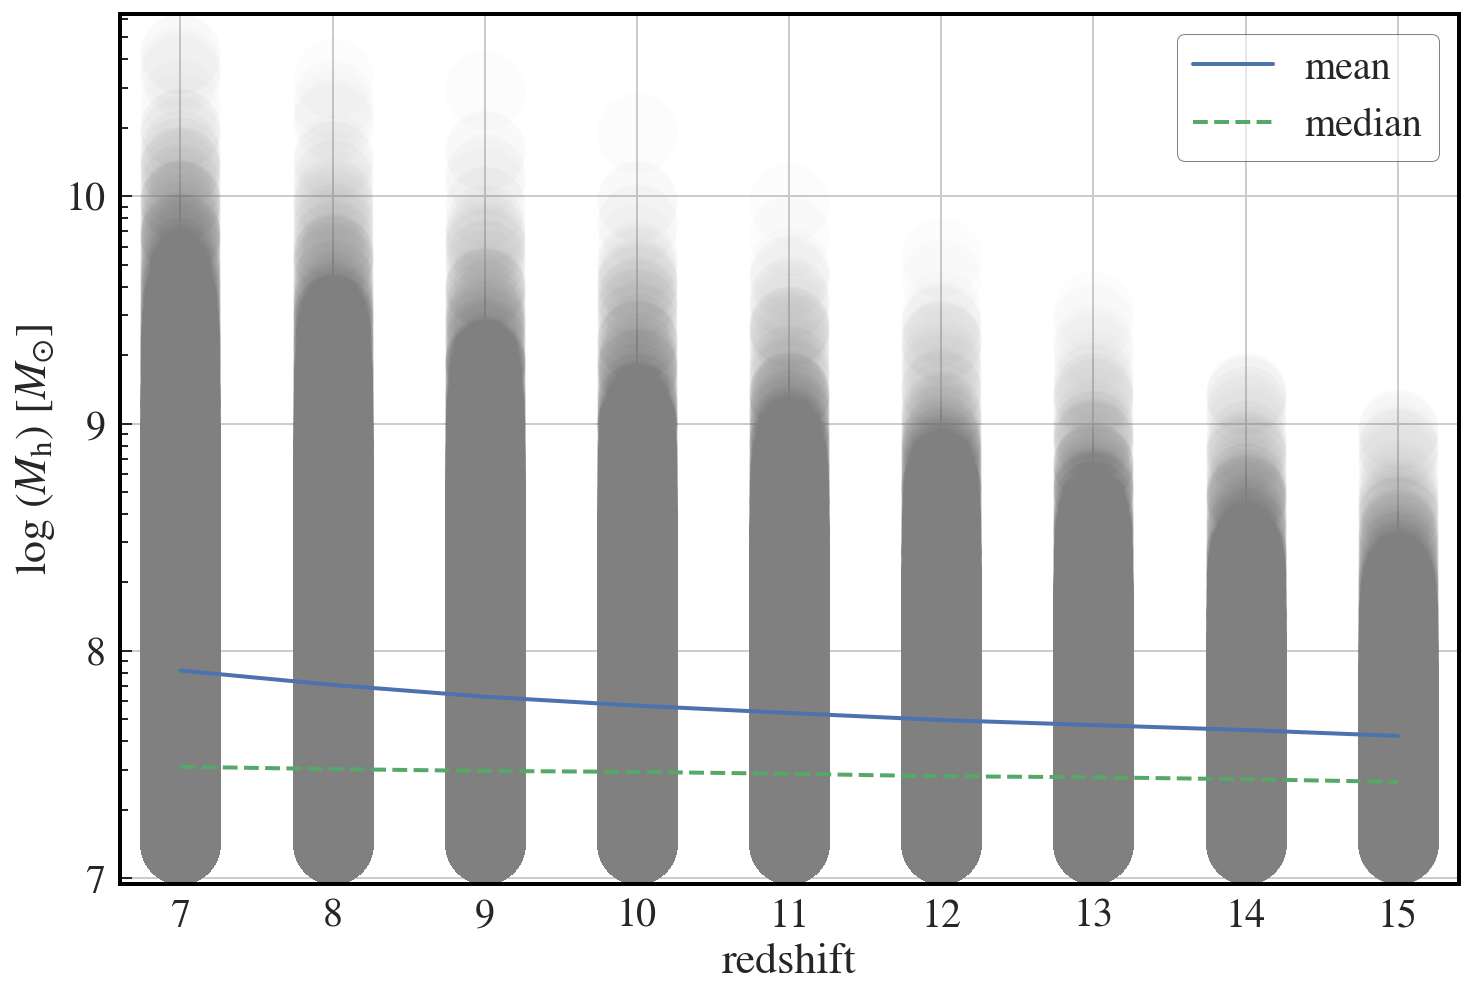

In [129]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

sn_energy = 8e53/1e51

the_zs   = sorted(num_to_z.values())
for i in the_zs:
    marker_style = dict(color='cornflowerblue', linestyle='none', marker='o',
                    markersize=35, markerfacecoloralt='gray',alpha=0.05)
    ax.plot(np.full(halos[i][1].size,i),halos[i][1],'C0o',
            markeredgewidth=0.0, markerfacecolor='grey', markersize=40,alpha=0.02)
ax.plot(the_zs,[halos[i][1].mean() for i in the_zs], lw=2, ls='-', c='C0',
        label='mean')
ax.plot(the_zs,[np.median(halos[i][1]) for i in the_zs], lw=2, ls='--', c='C1',
        label='median')

ax.set_yscale('log')
ax.yaxis.set_major_formatter(logfmt)
ax.yaxis.set_tick_params(which='major',width=1,length=6)
ax.yaxis.set_tick_params(which='minor',width=1,length=4)
ax.get_yaxis().set_tick_params(which='both', direction='in')
# ax.set_yticks([1e7,1e8])
# ax.set_yticklabels([7,7.3,8])

ax.set_xlabel('redshift')
ax.set_ylabel('log ($M_{\mathrm{h}}$) [$M_{\odot}$]')


lk = ax.legend(loc=0,framealpha=0.55, fancybox=True, edgecolor='k')
lk.get_frame().set_linewidth(0.5)
lk.set_frame_on(True)

# plt.savefig("HMR-DM.pdf".format(dir),dpi=fig.dpi,bbox_inches='tight')

In [146]:
np.logspace(7,11,41)

array([  1.00000000e+07,   1.25892541e+07,   1.58489319e+07,   1.99526231e+07,   2.51188643e+07,   3.16227766e+07,   3.98107171e+07,   5.01187234e+07,   6.30957344e+07,
         7.94328235e+07,   1.00000000e+08,   1.25892541e+08,   1.58489319e+08,   1.99526231e+08,   2.51188643e+08,   3.16227766e+08,   3.98107171e+08,   5.01187234e+08,
         6.30957344e+08,   7.94328235e+08,   1.00000000e+09,   1.25892541e+09,   1.58489319e+09,   1.99526231e+09,   2.51188643e+09,   3.16227766e+09,   3.98107171e+09,
         5.01187234e+09,   6.30957344e+09,   7.94328235e+09,   1.00000000e+10,   1.25892541e+10,   1.58489319e+10,   1.99526231e+10,   2.51188643e+10,   3.16227766e+10,
         3.98107171e+10,   5.01187234e+10,   6.30957344e+10,   7.94328235e+10,   1.00000000e+11])

/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(127320, 7) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(104661, 8) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(81823, 9) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(60865, 10) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/anaconda/envs/

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Largest bin value: -0.464, smallest -4.912875398647574


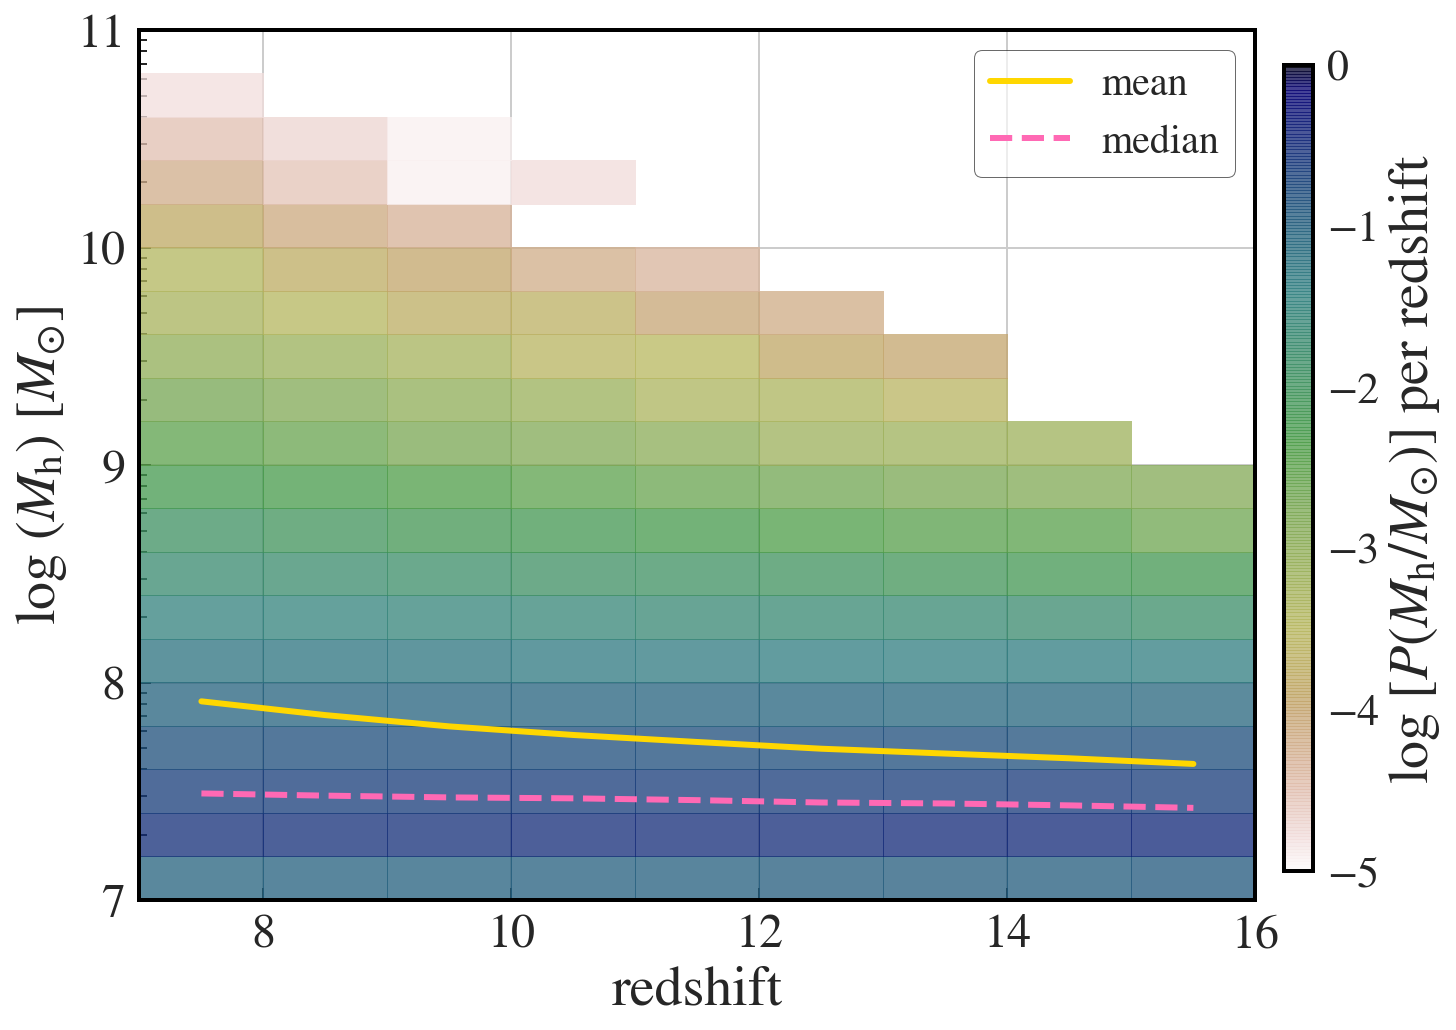

In [191]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes()

sn_energy = 8e53/1e51

the_zs   = sorted(num_to_z.values())
massBins = np.logspace(7,11,21)
zBins    = np.linspace(7,16,10)

data      = np.concatenate([halos[i][1].flatten() for i in the_zs],0)
redshifts = np.concatenate([np.full(len(halos[i][1]),i).flatten() for i in the_zs])

nTempA, binsx, binsy = np.histogram2d(data,redshifts,bins=[massBins,zBins],normed=False)

X, Y = np.meshgrid(zBins, massBins)  # Create a grid over the range of bins for the plot

# Mask out 0 values before taking log10... 
H = np.ma.masked_where(nTempA==0.0, nTempA)
for i in range(len(H[0,:])):     # Column index i, over len of row 0
    colTot = np.sum(H[:,i])
    for j in range(len(H[:,0])): # Row index j, over len of column 0
        H[:,i][j] = H[:,i][j]/colTot
    print(np.sum(H[:,i]))
H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
# Create the plot
im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-5, vmax=0, alpha=0.75) )
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label(r"log $\left[P(M_{\mathrm{h}}/M_{\odot})\right]$ per redshift",fontsize=28)

ax.plot(np.array(the_zs)+.5,[halos[i][1].mean() for i in the_zs], lw=3, ls='-', c='gold',
        label='mean')
ax.plot(np.array(the_zs)+.5,[np.median(halos[i][1]) for i in the_zs], lw=3, ls='--', c='hotpink',
        label='median')

ax.set_yscale('log')
ax.yaxis.set_major_formatter(logfmt)
ax.yaxis.set_tick_params(which='major',width=1,length=6)
ax.yaxis.set_tick_params(which='minor',width=1,length=4)
ax.get_yaxis().set_tick_params(which='both', direction='in')
ax.xaxis.set_tick_params(which='major',width=1,length=6)
ax.xaxis.set_tick_params(which='both', direction='in')
ax.get_xaxis().set_tick_params(labelsize=24)
ax.get_yaxis().set_tick_params(labelsize=24)
ax.grid()
# ax.set_yticks([1e7,1e8])
# ax.set_yticklabels([7,7.3,8])

ax.set_xlabel('redshift',fontsize=28)
ax.set_ylabel('log ($M_{\mathrm{h}}$) [$M_{\odot}$]',fontsize=28)


lk = ax.legend(loc=0,framealpha=0.65, fancybox=True, edgecolor='k')
lk.get_frame().set_linewidth(0.5)
lk.set_frame_on(True)

plt.savefig("HMR_DM-2d.pdf".format(dir),dpi=fig.dpi,bbox_inches='tight')

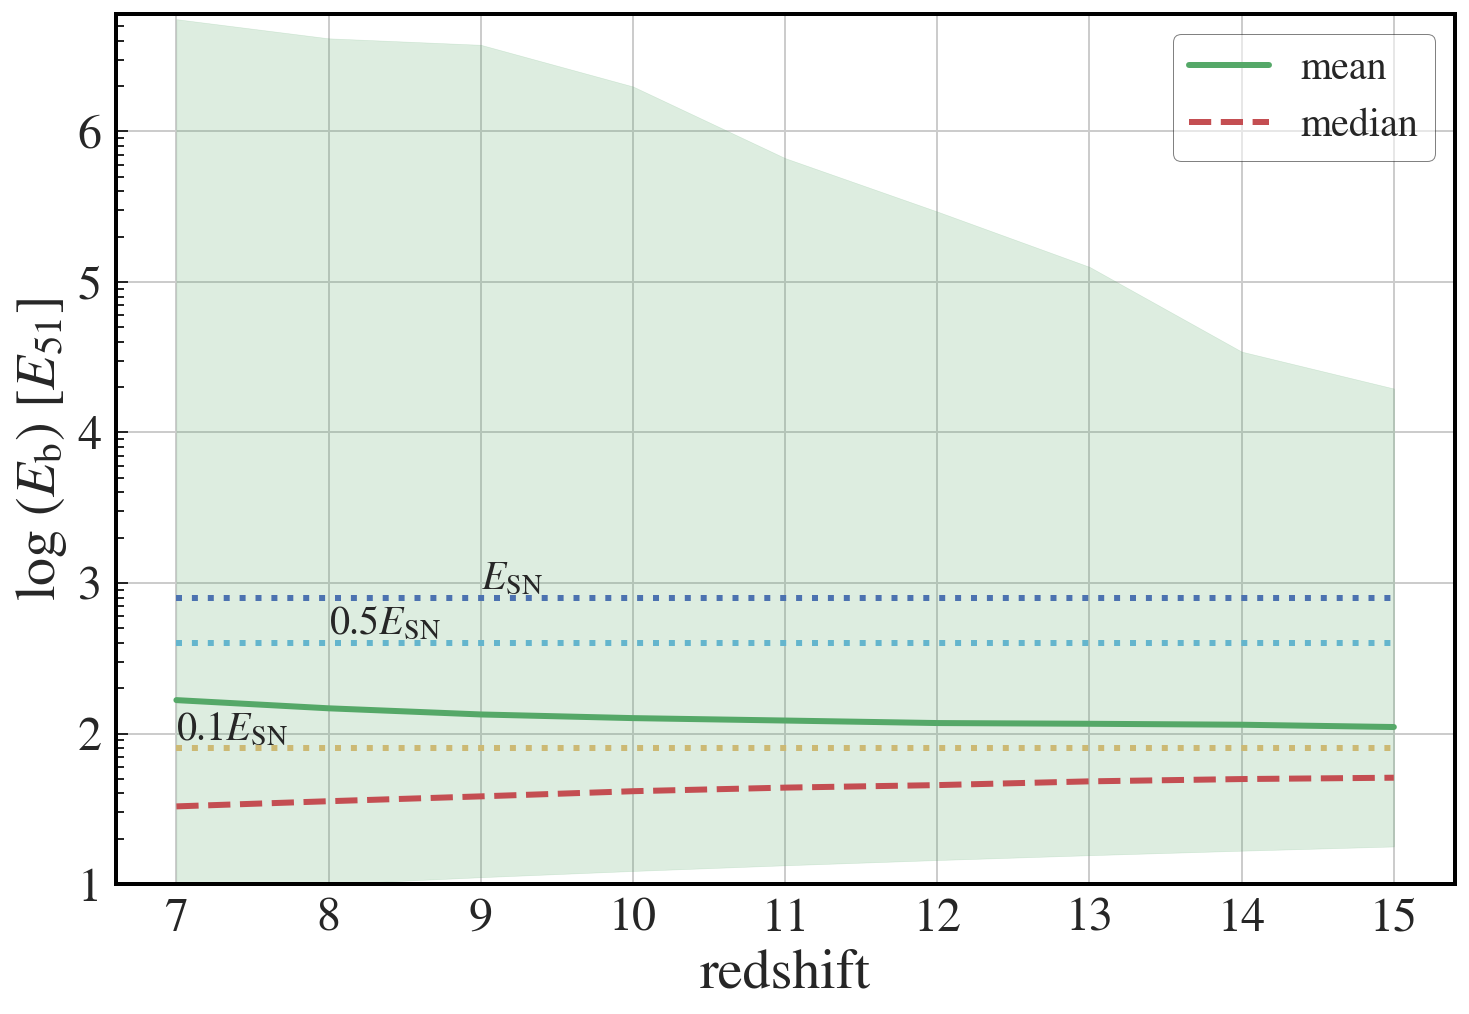

In [169]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

sn_energy = 8e53/1e51

the_zs   = sorted(num_to_z.values())

ax.set_yscale('log')
ax.yaxis.set_tick_params(which='major',width=1,length=6)
ax.yaxis.set_tick_params(which='minor',width=1,length=4)
ax.get_yaxis().set_tick_params(which='both', direction='in')
ax.get_xaxis().set_tick_params(labelsize=24)
ax.get_yaxis().set_tick_params(labelsize=24)
ax.plot(the_zs,[bindingE(halos[i][1].mean(),i) for i in the_zs], lw=3, c='C1',
         label=r'mean')
ax.plot(the_zs,[bindingE(np.median(halos[i][1]),i) for i in the_zs], lw=3, ls='--', c='C2',
         label=r'median')
ax.fill_between(the_zs,
                 [bindingE(halos[i][1].min(),i) for i in the_zs],
                 [bindingE(halos[i][1].max(),i) for i in the_zs],  color='C1', alpha = 0.2)
# Add lines for typical SN energy
ax.plot(the_zs,np.full(len(num_to_z.keys()),sn_energy/10.0),lw = 3, ls=":", c='C4')
ax.annotate(r'$0.1 {E_{\mathrm{SN}}}$', xy = (0.5, 0.5), xytext = (7, sn_energy/10.0), xycoords='figure fraction',
            textcoords = 'data', ha = 'left', va = 'bottom',fontsize=20)
ax.plot(the_zs,np.full(len(num_to_z.keys()),sn_energy/2.0),lw = 3, ls=":", c='C5')
ax.annotate(r'$0.5 {E_{\mathrm{SN}}}$', xy = (0.5, 0.5), xytext = (8, sn_energy/2.0), xycoords='figure fraction',
            textcoords = 'data', ha = 'left', va = 'bottom',fontsize=20)
ax.plot(the_zs,np.full(len(num_to_z.keys()),sn_energy),lw = 3, ls=":", c='C6')
ax.annotate(r'${E_{\mathrm{SN}}}$', xy = (0.5, 0.5), xytext = (9, sn_energy), xycoords='figure fraction',
            textcoords = 'data', ha = 'left', va = 'bottom',fontsize=20)
# ax.set_ylim([30,200])
ax.set_ylim([10,6e6])
# ax.set_yticklabels([40,60,80,100])
ax.yaxis.set_major_formatter(logfmt)
# ax.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(logfmt)
# ax.yaxis.set_minor_formatter(logfmt)
ax.set_ylabel('log ($E_{\mathrm {b}}$) [$E_{\mathrm{51}}$]',fontsize=28)
ax.set_xlabel('redshift',fontsize=28)

lk = ax.legend(loc=0,framealpha=0.55, fancybox=True, edgecolor='k')
# lk = ax.legend(loc=1,framealpha=0.55, fancybox=True, edgecolor='k')
lk.get_frame().set_linewidth(0.5)
lk.set_frame_on(True)

plt.savefig("Ebinding.pdf".format(dir),dpi=fig.dpi,bbox_inches='tight')

In [153]:
data,redshifts,nTempA

(array([ 834.58105327,  503.04281575,  726.45434595, ...,   32.61471679,   61.65507342,   58.27811017]),
 array([  7.,   7.,   7., ...,  15.,  15.,  15.]),
 array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 

/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(127320, 7) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(104661, 8) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(81823, 9) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(60865, 10) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/anaconda/envs/

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Largest bin value: -0.632, smallest -5.077640389544002


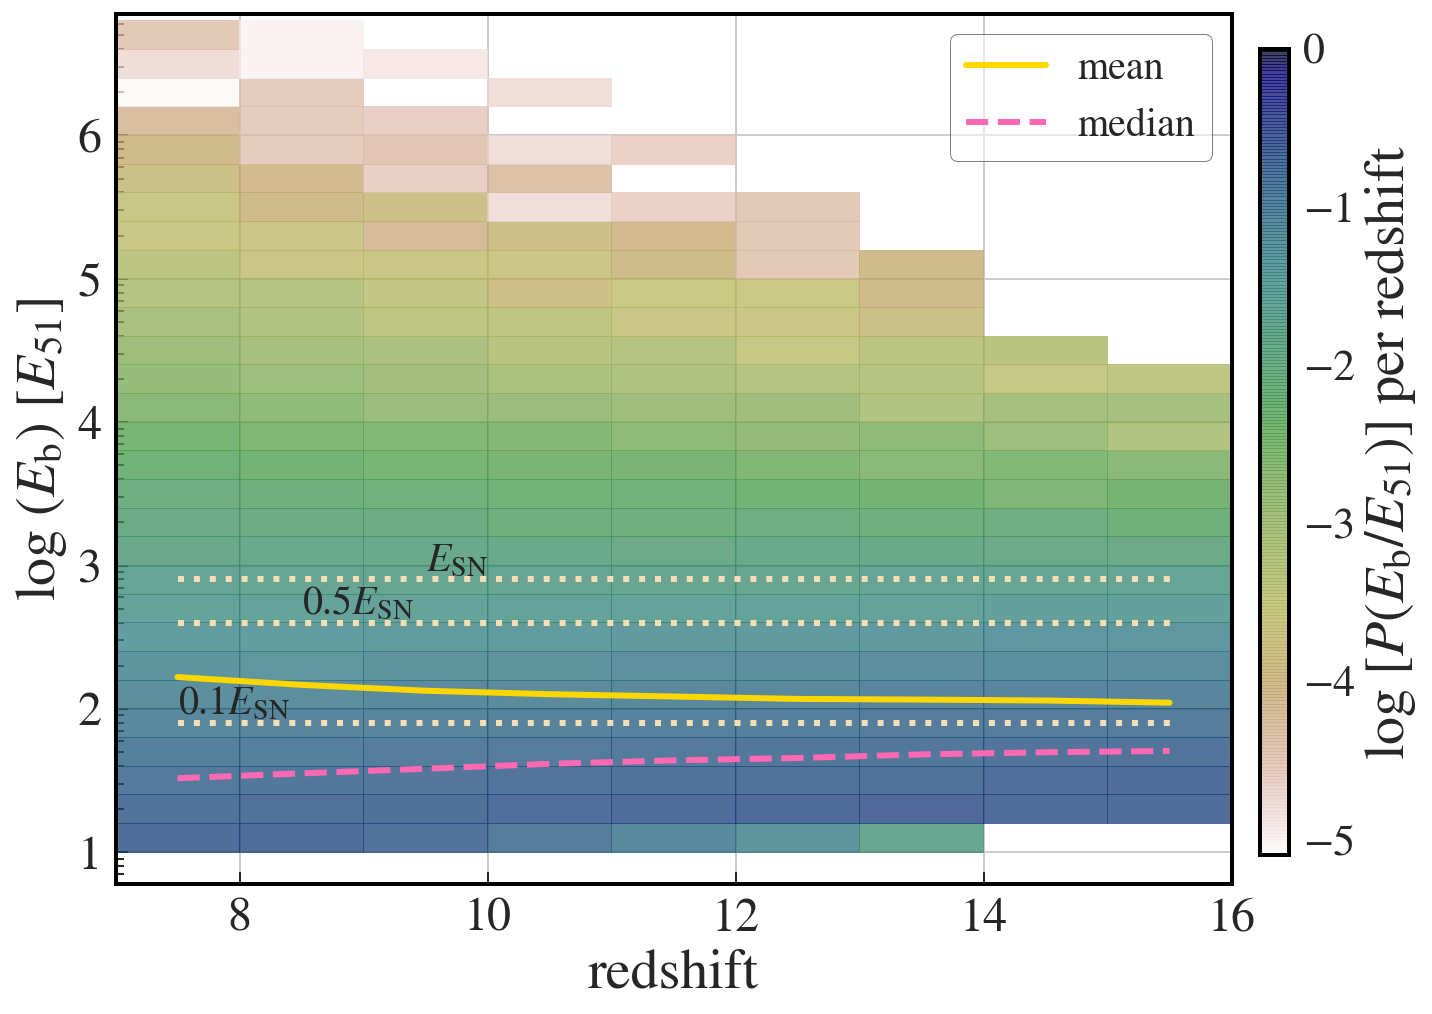

In [190]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes()

sn_energy = 8e53/1e51

the_zs   = sorted(num_to_z.values())
massBins = np.logspace(1,7,31)
zBins    = np.linspace(7,16,10)

data      = np.concatenate([bindingE(halos[i][1],i).flatten() for i in the_zs],0)
redshifts = np.concatenate([np.full(len(halos[i][1]),i).flatten() for i in the_zs])

nTempA, binsx, binsy = np.histogram2d(data,redshifts,bins=[massBins,zBins],normed=False)

X, Y = np.meshgrid(zBins, massBins)  # Create a grid over the range of bins for the plot

# Mask out 0 values before taking log10... 
H = np.ma.masked_where(nTempA==0.0, nTempA)
for i in range(len(H[0,:])):     # Column index i, over len of row 0
    colTot = np.sum(H[:,i])
    for j in range(len(H[:,0])): # Row index j, over len of column 0
        H[:,i][j] = H[:,i][j]/colTot
    print(np.sum(H[:,i]))
H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
# Create the plot
im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-5.1, vmax=0, alpha=0.75) )
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label(r"log $\left[P(E_{\mathrm{b}}/E_{\mathrm{51}})\right]$ per redshift",fontsize=28)

# Add lines for typical SN energy
ax.plot(np.array(the_zs)+0.5,np.full(len(num_to_z.keys()),sn_energy/10.0),lw = 3, ls=":", c='wheat')
ax.annotate(r'$0.1 {E_{\mathrm{SN}}}$', xy = (0.5, 0.5), xytext = (7.5, sn_energy/10.0), xycoords='figure fraction',
            textcoords = 'data', ha = 'left', va = 'bottom',fontsize=20)
ax.plot(np.array(the_zs)+0.5,np.full(len(num_to_z.keys()),sn_energy/2.0),lw = 3, ls=":", c='wheat')
ax.annotate(r'$0.5 {E_{\mathrm{SN}}}$', xy = (0.5, 0.5), xytext = (8.5, sn_energy/2.0), xycoords='figure fraction',
            textcoords = 'data', ha = 'left', va = 'bottom',fontsize=20)
ax.plot(np.array(the_zs)+0.5,np.full(len(num_to_z.keys()),sn_energy),lw = 3, ls=":", c='wheat')
ax.annotate(r'${E_{\mathrm{SN}}}$', xy = (0.5, 0.5), xytext = (9.5, sn_energy), xycoords='figure fraction',
            textcoords = 'data', ha = 'left', va = 'bottom',fontsize=20)

ax.plot(np.array(the_zs)+0.5,[bindingE(halos[i][1].mean(),i) for i in the_zs], lw=3, c='gold',
         label=r'mean')
ax.plot(np.array(the_zs)+0.5,[bindingE(np.median(halos[i][1]),i) for i in the_zs], lw=3, ls='--', c='hotpink',
         label=r'median')

ax.yaxis.set_tick_params(which='major',width=1,length=6)
ax.yaxis.set_tick_params(which='minor',width=1,length=4)
ax.get_yaxis().set_tick_params(which='both', direction='in')
ax.xaxis.set_tick_params(which='major',width=1,length=6)
ax.xaxis.set_tick_params(which='both', direction='in')
ax.get_xaxis().set_tick_params(labelsize=24)
ax.get_yaxis().set_tick_params(labelsize=24)
ax.set_yscale('log')
ax.set_ylim([6,7e6])
ax.grid()

# ax.set_yticklabels([40,60,80,100])
ax.yaxis.set_major_formatter(logfmt)
# ax.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(logfmt)
# ax.yaxis.set_minor_formatter(logfmt)
ax.set_ylabel('log ($E_{\mathrm {b}}$) [$E_{\mathrm{51}}$]',fontsize=28)
ax.set_xlabel('redshift',fontsize=28)

lk = ax.legend(loc=0,framealpha=0.55, fancybox=True, edgecolor='k')
# lk = ax.legend(loc=1,framealpha=0.55, fancybox=True, edgecolor='k')
lk.get_frame().set_linewidth(0.5)
lk.set_frame_on(True)


plt.savefig("Ebinding-2d.pdf".format(dir),dpi=fig.dpi,bbox_inches='tight')

In [192]:
# Binding energy of halo median mass
[bindingE(np.median(halos[i][1]),i) for i in the_zs]

[32.801003230503753,
 35.499729959348002,
 38.233069012151383,
 41.373040196160673,
 43.708582631042006,
 45.421441774077522,
 48.105457395008202,
 49.823408458390759,
 50.857246705304767]

In [195]:
# Median of binding energy of all halo mass
[np.median(bindingE(halos[i][1],i)) for i in the_zs]

[32.801003230503753,
 35.499729959348002,
 38.233069012151383,
 41.373040196160673,
 43.708582631042006,
 45.421441774077522,
 48.105457395008202,
 49.823408458390759,
 50.857246705304767]

In [202]:
#
np.array([halos[i][1][halos[i][1] < sn_energy/10.0] for i in the_zs])

array([], shape=(9, 0), dtype=float64)

In [199]:
sn_energy/10.0

80.0

In [26]:
# Fraction of halos, by number, that have less binding energy than 1/10 SN energy
fracsUnbound = np.array([bindingE(halos[i][1],i)[bindingE(halos[i][1],i) < sn_energy/10.0].size /  \
         bindingE(halos[i][1],i).size for i in the_zs])
print(fracsUnbound)
fracsUnbound.mean()

[ 0.71164782  0.70364319  0.69228701  0.68078534  0.67391003  0.66247719  0.65342267  0.64844659  0.63939764]


0.67400194237947852

In [28]:
# Mass fraction of halos, by number, that have less binding energy than 1/10 SN energy
massFracsUnbound = np.array([halos[i][1][bindingE(halos[i][1],i) < sn_energy/10.0].sum() /  \
 halos[i][1].sum() for i in the_zs])
print(massFracsUnbound)
massFracsUnbound.mean()

[ 0.22915425  0.2545266   0.27363222  0.28744412  0.29967293  0.30648321  0.31236002  0.31937751  0.32446025]


0.28967901110601246

/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(127320, 7) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(104661, 8) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(81823, 9) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/.conda/envs/py3k/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(60865, 10) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/earnric/.conda/envs/py3k/lib/p

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Largest bin value: -0.632, smallest -5.077640389544002


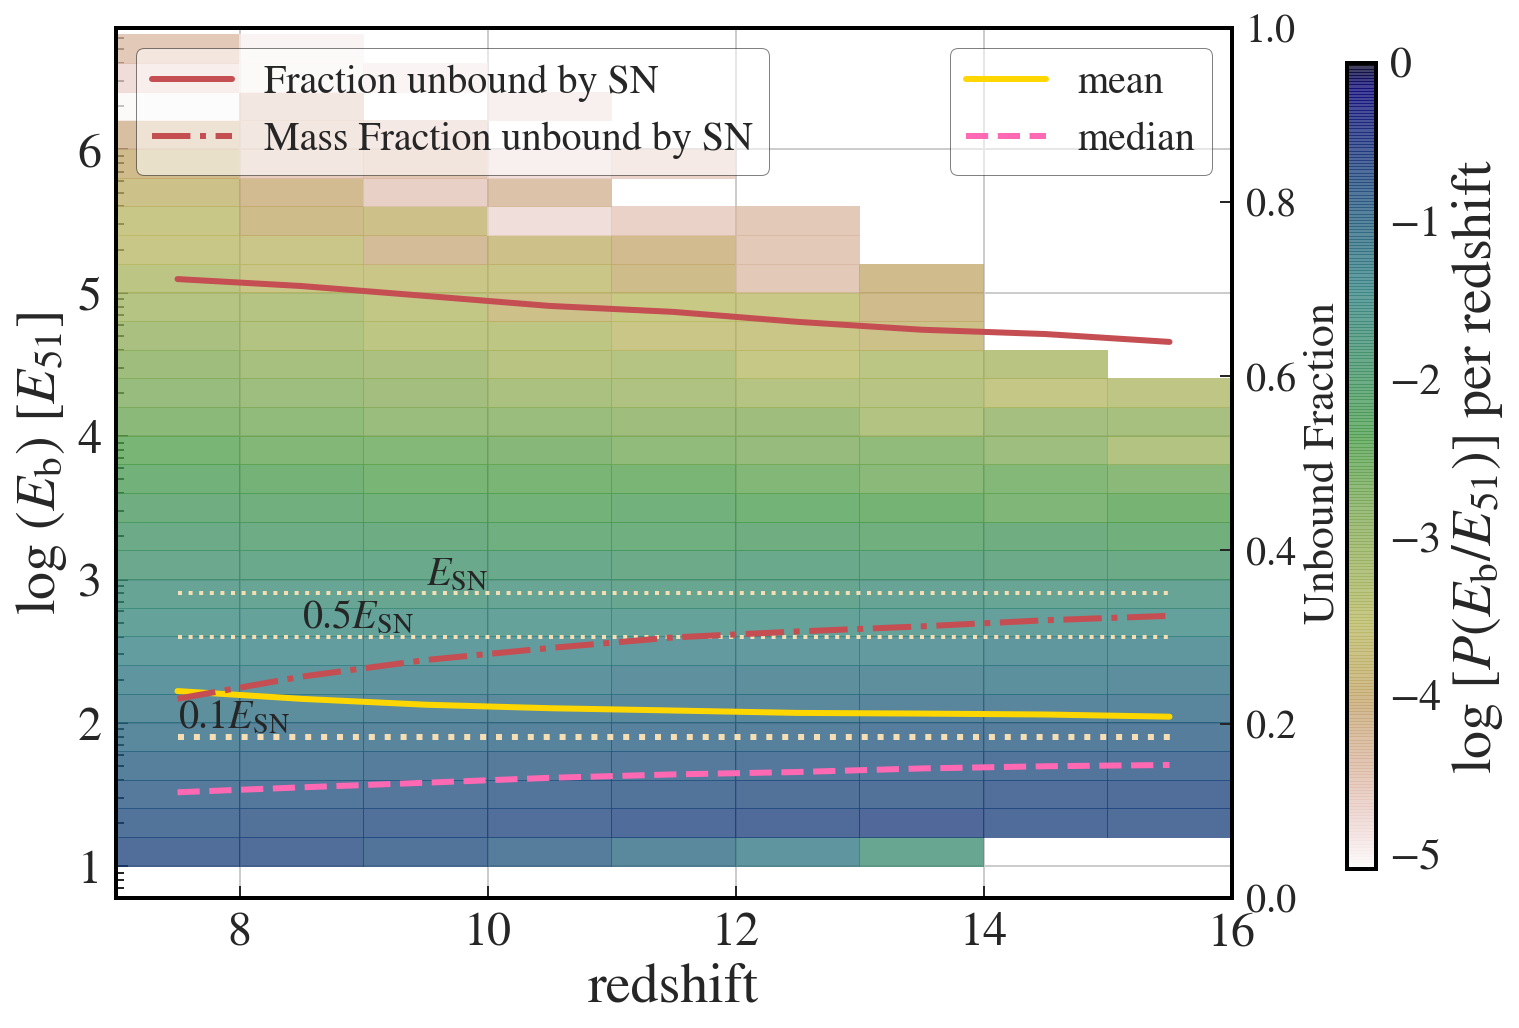

In [29]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes()

sn_energy = 8e53/1e51

the_zs   = sorted(num_to_z.values())
massBins = np.logspace(1,7,31)
zBins    = np.linspace(7,16,10)

data      = np.concatenate([bindingE(halos[i][1],i).flatten() for i in the_zs],0)
redshifts = np.concatenate([np.full(len(halos[i][1]),i).flatten() for i in the_zs])

nTempA, binsx, binsy = np.histogram2d(data,redshifts,bins=[massBins,zBins],normed=False)

X, Y = np.meshgrid(zBins, massBins)  # Create a grid over the range of bins for the plot

# Mask out 0 values before taking log10... 
H = np.ma.masked_where(nTempA==0.0, nTempA)
for i in range(len(H[0,:])):     # Column index i, over len of row 0
    colTot = np.sum(H[:,i])
    for j in range(len(H[:,0])): # Row index j, over len of column 0
        H[:,i][j] = H[:,i][j]/colTot
    print(np.sum(H[:,i]))
H = np.log10(H)        # Take log of counts, we've already normalized by volume and area
print("Largest bin value: {:.3f}, smallest {}".format(H.max(),H.min()))
# Create the plot
im = (ax.pcolormesh(X, Y, H, cmap=mpl.cm.gist_earth_r, vmin=-5.1, vmax=0, alpha=0.75) )
cbar_ax = fig.add_axes([0.98, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.tick_params(labelsize=22) 
#cbar.ax.set_yticklabels(['1', '2', '4', '6', '10', maxCV], size=24)
cbar.set_label(r"log $\left[P(E_{\mathrm{b}}/E_{\mathrm{51}})\right]$ per redshift",fontsize=28)

# Add lines for typical SN energy
ax.plot(np.array(the_zs)+0.5,np.full(len(num_to_z.keys()),sn_energy/10.0),lw = 3, ls=":", c='wheat')
ax.annotate(r'$0.1 {E_{\mathrm{SN}}}$', xy = (0.5, 0.5), xytext = (7.5, sn_energy/10.0), xycoords='figure fraction',
            textcoords = 'data', ha = 'left', va = 'bottom',fontsize=20)
ax.plot(np.array(the_zs)+0.5,np.full(len(num_to_z.keys()),sn_energy/2.0),lw = 2, ls=":", c='wheat')
ax.annotate(r'$0.5 {E_{\mathrm{SN}}}$', xy = (0.5, 0.5), xytext = (8.5, sn_energy/2.0), xycoords='figure fraction',
            textcoords = 'data', ha = 'left', va = 'bottom',fontsize=20)
ax.plot(np.array(the_zs)+0.5,np.full(len(num_to_z.keys()),sn_energy),lw = 2, ls=":", c='wheat')
ax.annotate(r'${E_{\mathrm{SN}}}$', xy = (0.5, 0.5), xytext = (9.5, sn_energy), xycoords='figure fraction',
            textcoords = 'data', ha = 'left', va = 'bottom',fontsize=20)

ax.plot(np.array(the_zs)+0.5,[bindingE(halos[i][1].mean(),i) for i in the_zs], lw=3, c='gold',
         label=r'mean')
ax.plot(np.array(the_zs)+0.5,[bindingE(np.median(halos[i][1]),i) for i in the_zs], lw=3, ls='--', c='hotpink',
         label=r'median')

ax.yaxis.set_tick_params(which='major',width=1,length=6)
ax.yaxis.set_tick_params(which='minor',width=1,length=4)
ax.get_yaxis().set_tick_params(which='both', direction='in')
ax.xaxis.set_tick_params(which='major',width=1,length=6)
ax.xaxis.set_tick_params(which='both', direction='in')
ax.get_xaxis().set_tick_params(labelsize=24)
ax.get_yaxis().set_tick_params(labelsize=24)
ax.set_yscale('log')
ax.set_xlim([7,16])
ax.set_ylim([6,7e6])

# ax.set_yticklabels([40,60,80,100])
ax.yaxis.set_major_formatter(logfmt)
# ax.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(logfmt)
# ax.yaxis.set_minor_formatter(logfmt)
ax.set_ylabel('log ($E_{\mathrm {b}}$) [$E_{\mathrm{51}}$]',fontsize=28)
ax.set_xlabel('redshift',fontsize=28)
ax.grid()


ax2 = ax.twinx() # Use the same x axis
ax2.set_yscale('linear')
ax2.yaxis.set_tick_params(which='major',width=1,length=6)
ax2.get_yaxis().set_tick_params(which='both', direction='in')
ax2.get_xaxis().set_tick_params(labelsize=24)
ax2.plot(np.array(the_zs)+0.5,fracsUnbound, lw=3, c='C2',
         label=r'Fraction unbound by SN')
ax2.plot(np.array(the_zs)+0.5,massFracsUnbound, lw=3, c='C2', ls='-.',
         label=r'Mass Fraction unbound by SN')
ax2.set_ylim([0,1])
# ax2.yaxis.set_minor_formatter(logfmt)
ax2.set_ylabel('Unbound Fraction')
ax2.grid(False)


lk = ax.legend(loc=1,framealpha=0.55, fancybox=True, edgecolor='k')
# lk = ax.legend(loc=1,framealpha=0.55, fancybox=True, edgecolor='k')
lk.get_frame().set_linewidth(0.5)
lk.set_frame_on(True)

lk2= ax2.legend(loc=2,framealpha=0.55, fancybox=True, edgecolor='k')
lk2.get_frame().set_linewidth(0.5)
lk2.set_frame_on(True)

plt.savefig("Ebinding-2d2.pdf".format(dir),dpi=fig.dpi,bbox_inches='tight')

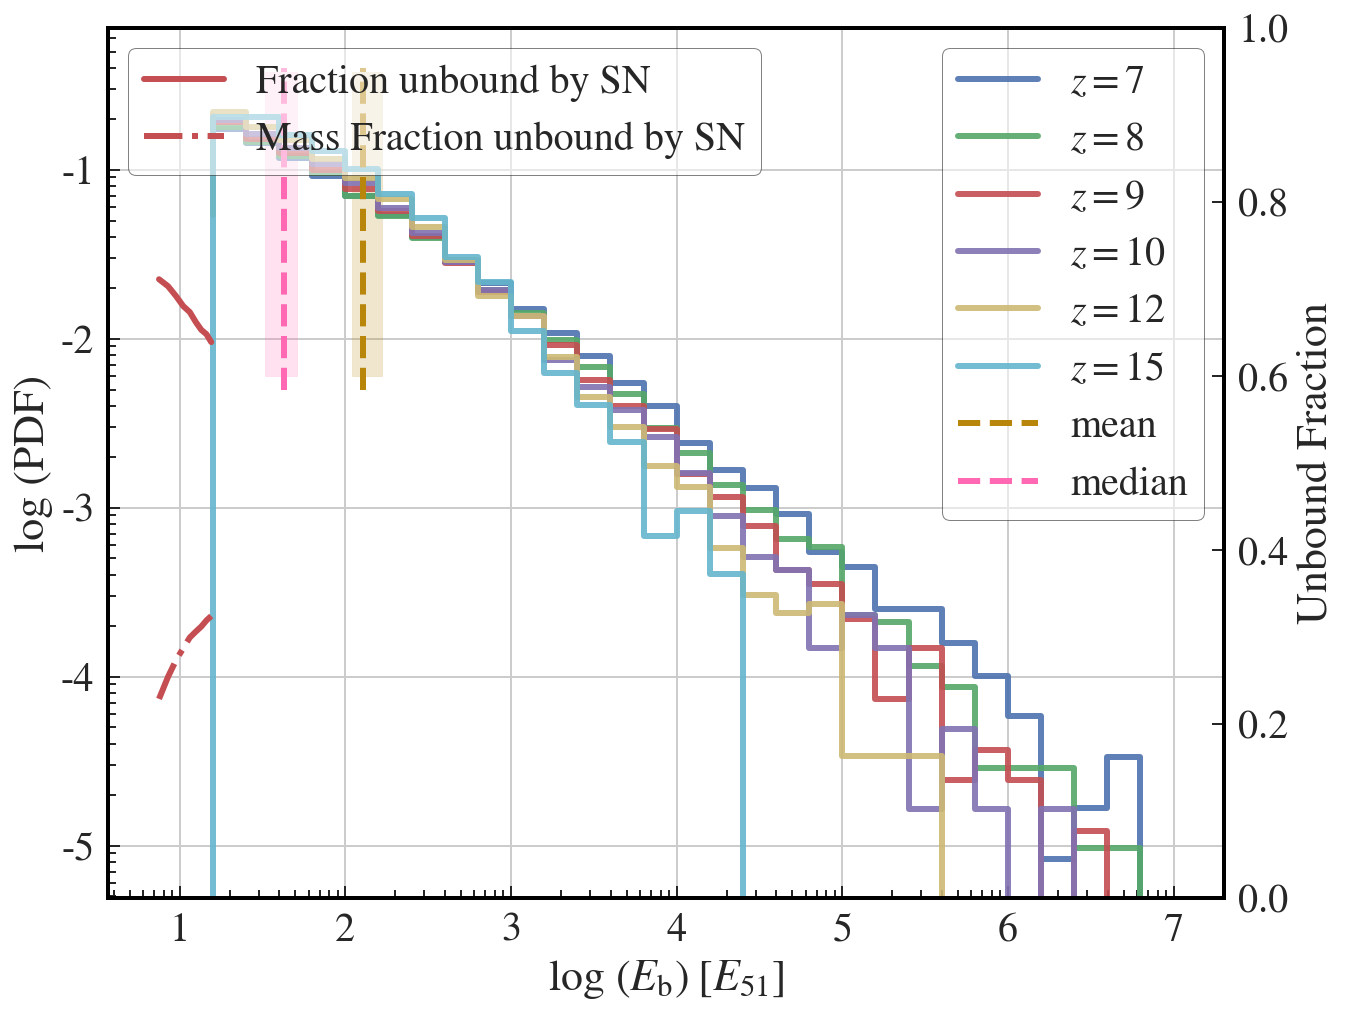

In [32]:
### WORK IN PROGRESS... 


fig = plt.figure(figsize=(10,8))
ax = plt.axes()

sn_energy = 8e53/1e51 # Based on the SP mass, fraction of SP mass that goes SN and SN energy per 10 M_sun (10^51 erg/10 M_sun)

bbins = np.logspace(1,7,31)

colors = ['C0','C1','C2','C3','C4','C4','C5','C5','C5']
for i,c in zip(sorted(num_to_z.values()),colors):
    if i in [11,13,14]:
        continue
    n, bins = np.histogram(bindingE(halos[i][1],i),bins=bbins,density=False)
    # Normalize to 1 over entire range... Make PDF
    n = n/n.sum()
    ax.plot(bbins[1:], n, '-', drawstyle='steps', lw=3.0, color=c, alpha=0.90, label="$z=${}".format(i) )


ax.plot([mean_Eb,mean_Eb],[5e-3,.4], ls='--', lw=3, c='darkgoldenrod',
         label=r'mean')
ax.axvspan(low_Mean_Eb,hi_Mean_Eb, ymin=0.6, ymax=0.95, alpha=0.20, color='darkgoldenrod')
ax.plot([median_Eb, median_Eb], [5e-3,.4], lw=3, ls='--', c='hotpink',
         label=r'median')
ax.axvspan(low_Med_Eb,hi_Med_Eb, ymin=0.6, ymax=0.95, alpha=0.20, color='hotpink')

#     plt.plot([halos[i][1].mean(),halos[i][1].mean()],[1e0,4e4])
ax.set_yscale('log')
ax.set_xscale('log')
ax.yaxis.set_tick_params(which='major',width=1,length=6)
ax.yaxis.set_tick_params(which='minor',width=1,length=4)
ax.yaxis.set_tick_params(which='both', direction='in')
ax.xaxis.set_tick_params(which='major',width=1,length=6)
ax.xaxis.set_tick_params(which='minor',width=1,length=4)
ax.xaxis.set_tick_params(which='both', direction='in')

ax.set_xlabel('log $(E_{\mathrm {b}})\; [E_{\mathrm{51}}]$')
ax.set_ylabel('log (PDF)')
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)


ax2 = ax.twinx() # Use the same x axis
ax2.set_yscale('linear')
ax2.yaxis.set_tick_params(which='major',width=1,length=6)
ax2.get_yaxis().set_tick_params(which='both', direction='in')
ax2.get_xaxis().set_tick_params(labelsize=24)
ax2.plot(np.array(the_zs)+0.5,fracsUnbound, lw=3, c='C2',
         label=r'Fraction unbound by SN')
ax2.plot(np.array(the_zs)+0.5,massFracsUnbound, lw=3, c='C2', ls='-.',
         label=r'Mass Fraction unbound by SN')
ax2.set_ylim([0,1])
# ax2.yaxis.set_minor_formatter(logfmt)
ax2.set_ylabel('Unbound Fraction')
ax2.grid(False)


lk = ax.legend(loc=1,framealpha=0.55, fancybox=True, edgecolor='k')
# lk = ax.legend(loc=1,framealpha=0.55, fancybox=True, edgecolor='k')
lk.get_frame().set_linewidth(0.5)
lk.set_frame_on(True)

lk2= ax2.legend(loc=2,framealpha=0.55, fancybox=True, edgecolor='k')
lk2.get_frame().set_linewidth(0.5)
lk2.set_frame_on(True)

plt.savefig("Fracs-2d2.pdf".format(dir),dpi=fig.dpi,bbox_inches='tight')